In [260]:
import spacy
from spacy.tokens import Doc
from spacy.tokens import DocBin
from spacy.matcher import Matcher
from spacy.lang.char_classes import ALPHA, ALPHA_LOWER, ALPHA_UPPER, CONCAT_QUOTES, LIST_ELLIPSES, LIST_ICONS, HYPHENS
from spacy.util import compile_infix_regex

from numpy import array

import scispacy
import pandas as pd
import en_core_sci_lg
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, KeyedVectors

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Flatten, Dropout
from tensorflow.keras.layers import TextVectorization

seed = 100

import random
import numpy as np
import tensorflow as tf
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [261]:
df1 = pd.read_csv ('data_files/positive_expression.tsv', sep='\t')
df1['Label'] = 1

df2 = pd.read_csv ('data_files/neg_sentences_otherexpr_with_expression.txt', sep='\t', header=None)
df2 = df2.rename(columns={0: "id", 1: "Sentence"})
df2['Label'] = 0

df = pd.concat([df1[['Sentence', 'Label']], df2[['Sentence', 'Label']]], ignore_index=True)
print(df.head())

                                            Sentence  Label
0  In addition to the neuronal and intestinal exp...      1
1  Results from RNA in situ hybridization confirm...      1
2  Microscopic evaluation of acs-1(gk3066);Ex[acs...      1
3  (C,D) DIC and corresponding fluorescent images...      1
4  In wild-type early embryos, ANI-1::GFP localiz...      1


In [262]:
#Doc.set_extension("positive", default=False)

pos_text_docs = df.loc[(df['Label'] == 1)]['Sentence'].astype(str).values.tolist()
neg_text_docs = df.loc[(df['Label'] == 0)]['Sentence'].astype(str).values.tolist()
print("Pos: ", len(pos_text_docs))
print("Neg: ", len(neg_text_docs))

nlp = spacy.load("en_core_sci_md")

pos_docs = list(nlp.pipe(pos_text_docs[:4000]))
neg_docs = list(nlp.pipe(neg_text_docs[:4000]))
for doc in pos_docs:
    doc._.positive = True

docs = []
docs.extend(pos_docs)
docs.extend(neg_docs)

print(len(docs))
random.shuffle(docs)

Pos:  386
Neg:  219
605


In [263]:
from utils.print_tree import print_tree

vocab, index = {}, 1  # start indexing from 1
vocab['<pad>'] = 0  # add a padding token


tuples = []
labels = []
for i in range(0, len(docs)):
    
    node_list = []
    edge_list = []
    sent_len = i
    #print(sent_len, ":", docs[sent_len])
    for sent in docs[sent_len].sents:
        for token in sent:
            node_list.append([token, True])
        print_tree(sent.root, node_list, edge_list, 0)    
        break

    #print(vocab)
    for edge in edge_list:
        if edge[0].text.lower() not in vocab:
            vocab[edge[0].text.lower()] = index
            index += 1
        if edge[1].text.lower() not in vocab:
            vocab[edge[1].text.lower()] = index
            index += 1
            
        tuples.append([vocab[str(edge[0]).lower()], vocab[str(edge[1]).lower()]])
        
        if docs[sent_len]._.positive:
            labels.append(1)
        else:
            labels.append(0)

inverse_vocab = {index: token for token, index in vocab.items()}
vocab_size = len(vocab)
print("Vocab Size", vocab_size)

print(len(tuples))
print(len(labels))

#print(tuples[:300])
#print(inverse_vocab)

Vocab Size 3079
8215
8215


In [264]:
tuples = array(tuples)
labels = array(labels)

print(tuples)
print(labels)

from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(tuples, labels, test_size=0.20)
data_val, data_test, labels_val, labels_test = train_test_split(data_test, labels_test, test_size=0.50)


[[  1   2]
 [  2   3]
 [  3   4]
 ...
 [318 745]
 [745 458]
 [745 386]]
[1 1 1 ... 1 1 1]


In [374]:
model = Sequential()
model.add(Embedding(vocab_size, 3, input_length=2))
model.add(Flatten())
model.add(Dropout(0.6))
#model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
# summarize the model
print(model.summary())
# fit the model
history = model.fit(data_train, labels_train, validation_data=(data_val, labels_val), epochs=65)

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 2, 3)              9237      
                                                                 
 flatten_51 (Flatten)        (None, 6)                 0         
                                                                 
 dropout_19 (Dropout)        (None, 6)                 0         
                                                                 
 dense_54 (Dense)            (None, 1)                 7         
                                                                 
Total params: 9,244
Trainable params: 9,244
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/65
206/206 [==============================] - 1s 2ms/step - loss: 0.6791 - accuracy: 0.5825 - precision: 0.6090 - recall: 0.8273 - val_loss: 0.6576 - val_accuracy: 0.6382

206/206 [==============================] - 0s 1ms/step - loss: 0.1980 - accuracy: 0.9145 - precision: 0.9015 - recall: 0.9607 - val_loss: 0.1877 - val_accuracy: 0.9172 - val_precision: 0.9089 - val_recall: 0.9599
Epoch 34/65
206/206 [==============================] - 0s 1ms/step - loss: 0.1972 - accuracy: 0.9066 - precision: 0.8923 - recall: 0.9582 - val_loss: 0.1862 - val_accuracy: 0.9172 - val_precision: 0.9089 - val_recall: 0.9599
Epoch 35/65
206/206 [==============================] - 0s 1ms/step - loss: 0.1884 - accuracy: 0.9163 - precision: 0.9009 - recall: 0.9651 - val_loss: 0.1860 - val_accuracy: 0.9147 - val_precision: 0.9070 - val_recall: 0.9579
Epoch 36/65
206/206 [==============================] - 0s 1ms/step - loss: 0.1920 - accuracy: 0.9116 - precision: 0.8961 - recall: 0.9625 - val_loss: 0.1861 - val_accuracy: 0.9160 - val_precision: 0.9103 - val_recall: 0.9559
Epoch 37/65
206/206 [==============================] - 0s 1ms/step - loss: 0.1906 - accuracy: 0.9159 - precision

In [375]:
# evaluate the model
print("Test Set Size: ", len(data_test))
loss, accuracy, precision, recall = model.evaluate(data_test, labels_test)
print('Accuracy: %f' % (accuracy*100))

#model.save('models/sentence_model01')

Test Set Size:  822
26/26 [==============================] - 0s 889us/step - loss: 0.2097 - accuracy: 0.9185 - precision: 0.9273 - recall: 0.9436
Accuracy: 91.849148


In [376]:
import io

word_embeddings_layer = model.layers[0]
weights = word_embeddings_layer.get_weights()[0]
print("Word Embeddings shape: %s" % (weights.shape,))

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num in range(0, vocab_size):
    vec = weights[num] # skip 0, it's padding.
    out_m.write(inverse_vocab[num] + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

Word Embeddings shape: (3079, 3)


In [377]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

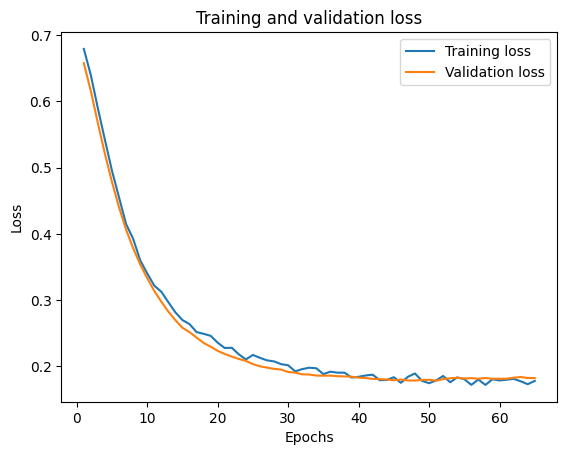

In [378]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label="Training loss")
plt.plot(epochs, val_loss_values, label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

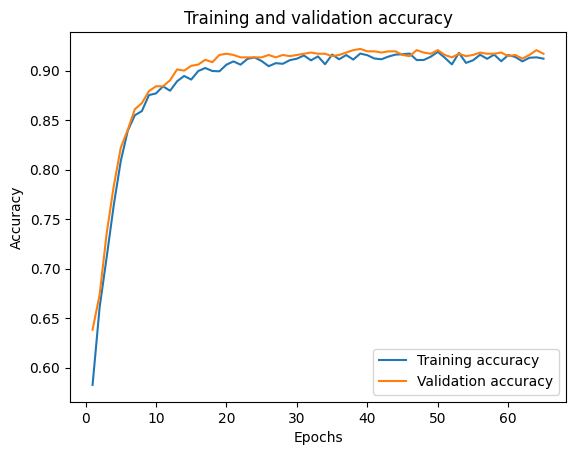

In [379]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

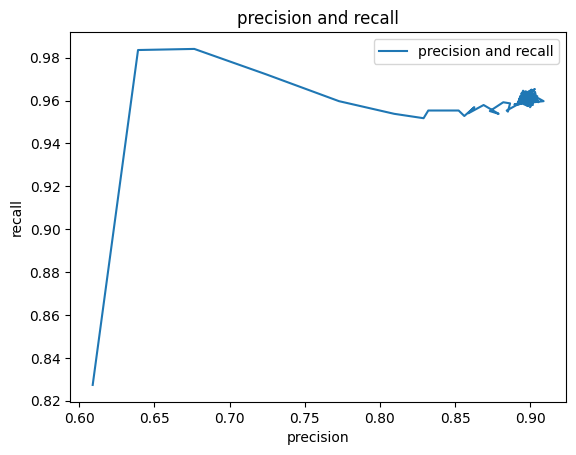

In [382]:
plt.clf()
acc = history.history["precision"]
val_acc = history.history["recall"]
plt.plot(acc, val_acc, label="precision and recall")
plt.title("precision and recall")
plt.xlabel("precision")
plt.ylabel("recall")
plt.legend()
plt.show()